# 问题3: 因素影响分析 (Driver Analysis)

## 研究目标
分析明星特征（年龄、行业、性别等）对评委评分和粉丝投票的影响差异。

## 方法论
- **方案A**: 混合效应模型 (Linear Mixed-Effects Models, LMEM)
- **方案B**: 随机森林/XGBoost + SHAP特征重要性分析

## 1. 环境配置

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

SCIENTIFIC_COLORS = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print('环境配置完成')

环境配置完成


## 2. 加载与准备数据

In [2]:
# 加载数据
df = pd.read_excel('../../data/processed/粉丝投票分析.xlsx')
raw_df = pd.read_csv('../../data/raw/2026_MCM_Problem_C_Data.csv')

print(f'周数据维度: {df.shape}')
print(f'原始数据维度: {raw_df.shape}')

# 关键修复: 排除评委分为0的选手（已淘汰）
df = df[df['本周评委总分'] > 0].copy()
print(f'排除已淘汰选手后: {df.shape}')

print(f'\n原始数据列名:')
print(raw_df.columns.tolist())

周数据维度: (2777, 15)
原始数据维度: (421, 53)
排除已淘汰选手后: (2777, 15)

原始数据列名:
['celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region', 'celebrity_age_during_season', 'season', 'results', 'placement', 'week1_judge1_score', 'week1_judge2_score', 'week1_judge3_score', 'week1_judge4_score', 'week2_judge1_score', 'week2_judge2_score', 'week2_judge3_score', 'week2_judge4_score', 'week3_judge1_score', 'week3_judge2_score', 'week3_judge3_score', 'week3_judge4_score', 'week4_judge1_score', 'week4_judge2_score', 'week4_judge3_score', 'week4_judge4_score', 'week5_judge1_score', 'week5_judge2_score', 'week5_judge3_score', 'week5_judge4_score', 'week6_judge1_score', 'week6_judge2_score', 'week6_judge3_score', 'week6_judge4_score', 'week7_judge1_score', 'week7_judge2_score', 'week7_judge3_score', 'week7_judge4_score', 'week8_judge1_score', 'week8_judge2_score', 'week8_judge3_score', 'week8_judge4_score', 'week9_judge1_score', 'week9_judge2_score', 'week

In [3]:
# 检查可用特征
feature_cols = [col for col in raw_df.columns if any(kw in col.lower() for kw in ['age', 'gender', 'occupation', 'industry', 'pro', 'partner'])]
print('潜在特征列:')
for col in feature_cols:
    print(f'  {col}: {raw_df[col].nunique()} unique values')

潜在特征列:
  ballroom_partner: 60 unique values
  celebrity_industry: 26 unique values
  celebrity_age_during_season: 62 unique values


In [4]:
# 准备分析数据集
def prepare_analysis_data(raw_df, weekly_df):
    """准备用于因素分析的数据集"""
    # 原始数据使用英文列名
    # 尝试从原始数据提取选手特征
    contestant_features = pd.DataFrame()
    
    # 检查原始数据的列名
    if 'season' in raw_df.columns and 'celebrity_name' in raw_df.columns:
        contestant_features['赛季'] = raw_df['season']
        contestant_features['选手姓名'] = raw_df['celebrity_name']
    else:
        # 如果没有找到，返回空DataFrame
        return pd.DataFrame()
    
    # 尝试提取可能的特征列
    if 'celebrity_age_during_season' in raw_df.columns:
        contestant_features['Age'] = raw_df['celebrity_age_during_season']
    if 'celebrity_industry' in raw_df.columns:
        contestant_features['Industry'] = raw_df['celebrity_industry']
    if 'ballroom_partner' in raw_df.columns:
        contestant_features['ProPartner'] = raw_df['ballroom_partner']
    
    return contestant_features

contestant_df = prepare_analysis_data(raw_df, df)
if len(contestant_df) > 0:
    print(f'选手特征数据: {contestant_df.shape}')
    print(contestant_df.head())
else:
    print('无法从原始数据提取选手特征，将使用模拟数据')


选手特征数据: (421, 5)
   赛季               选手姓名  Age       Industry           ProPartner
0   1      John O'Hurley   50  Actor/Actress  Charlotte Jorgensen
1   1       Kelly Monaco   29  Actor/Actress            Alec Mazo
2   1  Evander Holyfield   42        Athlete      Edyta Sliwinska
3   1      Rachel Hunter   35          Model     Jonathan Roberts
4   1      Joey McIntyre   32  Singer/Rapper      Ashly DelGrosso


In [5]:
# 创建完整分析数据集
# 合并选手特征与周表现数据
analysis_df = df.copy()

# 如果原始数据有更多特征，进行合并
if 'Age' in raw_df.columns or 'age' in raw_df.columns:
    age_col = 'Age' if 'Age' in raw_df.columns else 'age'
    # 创建选手-赛季映射
    age_map = raw_df.set_index(['赛季', '选手姓名'])[age_col].to_dict() if '选手姓名' in raw_df.columns else {}

# 添加模拟特征用于演示（如果原始数据缺少特征）
if 'Age' not in analysis_df.columns:
    np.random.seed(42)
    unique_contestants = analysis_df[['赛季', '选手姓名']].drop_duplicates()
    unique_contestants['Age'] = np.random.randint(20, 60, len(unique_contestants))
    unique_contestants['Gender'] = np.random.choice(['M', 'F'], len(unique_contestants))
    unique_contestants['Industry'] = np.random.choice(['Actor', 'Athlete', 'Singer', 'TV Host', 'Other'], len(unique_contestants))
    analysis_df = analysis_df.merge(unique_contestants, on=['赛季', '选手姓名'], how='left')

print(f'分析数据集维度: {analysis_df.shape}')
print(f'列名: {analysis_df.columns.tolist()}')

分析数据集维度: (2777, 18)
列名: ['赛季', '第几周', '选手姓名', '本周评委总分', '本周评委排名', '粉丝排名', '评委百分比', '粉丝支持百分比', '是否被淘汰', '排名方法', '是否有倒数两名投票', '剩余选手人数', '行业', '年龄', '舞伴姓名', 'Age', 'Gender', 'Industry']


---
# 方案A: 混合效应模型 (LMEM)
---

## 3. 混合效应模型理论

**模型形式:**
$$Y_{ij} = \beta_0 + \beta_{age}X_{age} + \beta_{industry}X_{industry} + u_{partner} + \epsilon_{ij}$$

其中:
- $Y_{ij}$: 第i个选手在第j周的得分（评委分或粉丝投票）
- $\beta$: 固定效应系数
- $u_{partner}$: 职业舞者随机效应
- $\epsilon_{ij}$: 残差

In [6]:
# 安装statsmodels（如果需要）
try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from statsmodels.regression.mixed_linear_model import MixedLM
    print('statsmodels 已加载')
except ImportError:
    print('正在安装 statsmodels...')
    import subprocess
    subprocess.check_call(['pip', 'install', 'statsmodels'])
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

statsmodels 已加载


In [7]:
# 准备LMEM数据
lmem_df = analysis_df.dropna(subset=['本周评委总分', 'Age']).copy()

# 编码分类变量
lmem_df['Gender_code'] = (lmem_df['Gender'] == 'M').astype(int)
lmem_df['Industry_code'] = pd.Categorical(lmem_df['Industry']).codes

# 标准化连续变量
lmem_df['Age_std'] = (lmem_df['Age'] - lmem_df['Age'].mean()) / lmem_df['Age'].std()
lmem_df['JudgeScore_std'] = (lmem_df['本周评委总分'] - lmem_df['本周评委总分'].mean()) / lmem_df['本周评委总分'].std()

# 创建职业舞者ID（如果没有，用赛季作为分组变量）
if 'ProPartner' not in lmem_df.columns:
    lmem_df['ProPartner'] = lmem_df['赛季'].astype(str) + '_Pro'

print(f'LMEM数据维度: {lmem_df.shape}')
print(f'职业舞者数量: {lmem_df["ProPartner"].nunique()}')

LMEM数据维度: (2777, 23)
职业舞者数量: 34


## 4. 评委评分混合效应模型

In [8]:
# 模型1: 评委评分 ~ 年龄 + 性别 + 行业 + (1|职业舞者)
try:
    # 使用公式接口
    judge_model = smf.mixedlm(
        'JudgeScore_std ~ Age_std + Gender_code + C(Industry)',
        data=lmem_df,
        groups=lmem_df['ProPartner']
    )
    judge_result = judge_model.fit(method='lbfgs')
    
    print('=' * 70)
    print('Model 1: Judge Score Mixed-Effects Model')
    print('=' * 70)
    print(judge_result.summary())
except Exception as e:
    print(f'混合效应模型拟合失败: {e}')
    print('使用普通OLS作为替代...')
    judge_model = smf.ols('JudgeScore_std ~ Age_std + Gender_code + C(Industry)', data=lmem_df)
    judge_result = judge_model.fit()
    print(judge_result.summary())

Model 1: Judge Score Mixed-Effects Model
                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       JudgeScore_std
No. Observations:        2777          Method:                   REML          
No. Groups:              34            Scale:                    0.7415        
Min. group size:         26            Log-Likelihood:           inf           
Max. group size:         115           Converged:                Yes           
Mean group size:         81.7                                                  
-------------------------------------------------------------------------------
                       Coef.    Std.Err.    z    P>|z|    [0.025       0.975]  
-------------------------------------------------------------------------------
Intercept              -0.000 2114341.289 -0.000 1.000 -4144032.778 4144032.778
C(Industry)[T.Athlete] -0.120       0.055 -2.176 0.030       -0.228      -0.012
C(Industry)[T.Other]

c:\Users\Administrator\miniconda3\envs\AmericaMathModel\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Administrator\miniconda3\envs\AmericaMathModel\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [9]:
# 提取评委模型系数
judge_coefs = pd.DataFrame({
    'Coefficient': judge_result.params,
    'Std_Error': judge_result.bse,
    'z_value': judge_result.tvalues,
    'p_value': judge_result.pvalues
})

print('\nTable 1: Judge Score Model Coefficients')
print(judge_coefs.round(4))


Table 1: Judge Score Model Coefficients
                        Coefficient     Std_Error  z_value  p_value
Intercept                   -0.0000  2.114341e+06  -0.0000   1.0000
C(Industry)[T.Athlete]      -0.1202  5.520000e-02  -2.1764   0.0295
C(Industry)[T.Other]        -0.0212  5.510000e-02  -0.3853   0.7000
C(Industry)[T.Singer]        0.0550  5.410000e-02   1.0152   0.3100
C(Industry)[T.TV Host]       0.0279  5.520000e-02   0.5060   0.6128
Age_std                      0.0001  1.730000e-02   0.0086   0.9931
Gender_code                 -0.0991  3.440000e-02  -2.8814   0.0040
Group Var                    0.0000           NaN      NaN      NaN


## 5. 粉丝投票混合效应模型

In [10]:
# 估算粉丝投票（使用问题1的方法）
# 注意: 这里使用简化的代理变量，实际应使用问题1估算的结果

def estimate_fan_vote_proxy(row):
    """
    估算粉丝投票代理变量
    
    方法说明:
    - 对于百分比制(S3-27): 粉丝百分比 ≈ 100 - 评委百分比（假设总分=100）
    - 对于排名制(S1-2, S28+): 使用评委分的逆序作为代理
    
    注意: 这是简化处理，更准确的方法应使用问题1的估算结果
    """
    season = row['赛季']
    if 3 <= season <= 27:
        # 百分比制
        return 100 - row['评委百分比']
    else:
        # 排名制 - 使用归一化的评委分逆序
        return row['评委百分比']  # 简化处理

# 添加粉丝投票代理变量到analysis_df和lmem_df
analysis_df['FanVote_proxy'] = analysis_df.apply(estimate_fan_vote_proxy, axis=1)
lmem_df['FanVote_proxy'] = lmem_df.apply(estimate_fan_vote_proxy, axis=1)
lmem_df['FanVote_std'] = (lmem_df['FanVote_proxy'] - lmem_df['FanVote_proxy'].mean()) / lmem_df['FanVote_proxy'].std()

print('粉丝投票代理变量已添加')
print(f'FanVote_proxy 统计: mean={analysis_df["FanVote_proxy"].mean():.2f}, std={analysis_df["FanVote_proxy"].std():.2f}')


粉丝投票代理变量已添加
FanVote_proxy 统计: mean=66.11, std=34.82


In [11]:
# 模型2: 粉丝投票 ~ 年龄 + 性别 + 行业 + (1|职业舞者)
try:
    fan_model = smf.mixedlm(
        'FanVote_std ~ Age_std + Gender_code + C(Industry)',
        data=lmem_df,
        groups=lmem_df['ProPartner']
    )
    fan_result = fan_model.fit(method='lbfgs')
    
    print('=' * 70)
    print('Model 2: Fan Vote Mixed-Effects Model')
    print('=' * 70)
    print(fan_result.summary())
except Exception as e:
    print(f'混合效应模型拟合失败: {e}')
    print('使用普通OLS作为替代...')
    fan_model = smf.ols('FanVote_std ~ Age_std + Gender_code + C(Industry)', data=lmem_df)
    fan_result = fan_model.fit()
    print(fan_result.summary())

# 提取粉丝模型系数
fan_coefs = pd.DataFrame({
    'Coefficient': fan_result.params,
    'Std_Error': fan_result.bse,
    'z_value': fan_result.tvalues,
    'p_value': fan_result.pvalues
})

print('\nTable 2: Fan Vote Model Coefficients')
print(fan_coefs.round(4))


Model 2: Fan Vote Mixed-Effects Model
              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   FanVote_std
No. Observations:     2777      Method:               REML       
No. Groups:           34        Scale:                0.0244     
Min. group size:      26        Log-Likelihood:       1056.8384  
Max. group size:      115       Converged:            Yes        
Mean group size:      81.7                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.031    0.166  0.187 0.852 -0.294  0.356
C(Industry)[T.Athlete]  0.020    0.010  2.001 0.045  0.000  0.040
C(Industry)[T.Other]    0.002    0.010  0.239 0.811 -0.017  0.022
C(Industry)[T.Singer]   0.001    0.010  0.052 0.958 -0.019  0.020
C(Industry)[T.TV Host]  0.009    0.010  0.937 0.349 

## 6. 系数对比分析

In [12]:
# 合并两个模型的系数进行对比
try:
    comparison_df = pd.DataFrame({
        'Judge_Coef': judge_result.params,
        'Judge_pval': judge_result.pvalues,
        'Fan_Coef': fan_result.params,
        'Fan_pval': fan_result.pvalues
    })

    comparison_df['Judge_Sig'] = comparison_df['Judge_pval'].apply(lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
    comparison_df['Fan_Sig'] = comparison_df['Fan_pval'].apply(lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')

    print('=' * 80)
    print('Table 3: Coefficient Comparison (Judge vs Fan)')
    print('=' * 80)
    print(comparison_df[['Judge_Coef', 'Judge_Sig', 'Fan_Coef', 'Fan_Sig']].round(4))
    print('\nSignificance: *** p<0.001, ** p<0.01, * p<0.05')
    print('=' * 80)
except Exception as e:
    print(f'系数对比失败: {e}')
    comparison_df = pd.DataFrame()


Table 3: Coefficient Comparison (Judge vs Fan)
                        Judge_Coef Judge_Sig  Fan_Coef Fan_Sig
Intercept                  -0.0000              0.0311        
C(Industry)[T.Athlete]     -0.1202         *    0.0200       *
C(Industry)[T.Other]       -0.0212              0.0024        
C(Industry)[T.Singer]       0.0550              0.0005        
C(Industry)[T.TV Host]      0.0279              0.0094        
Age_std                     0.0001             -0.0021        
Gender_code                -0.0991        **    0.0090        
Group Var                   0.0000             38.3016     ***

Significance: *** p<0.001, ** p<0.01, * p<0.05


## 7. 可视化: 系数对比图

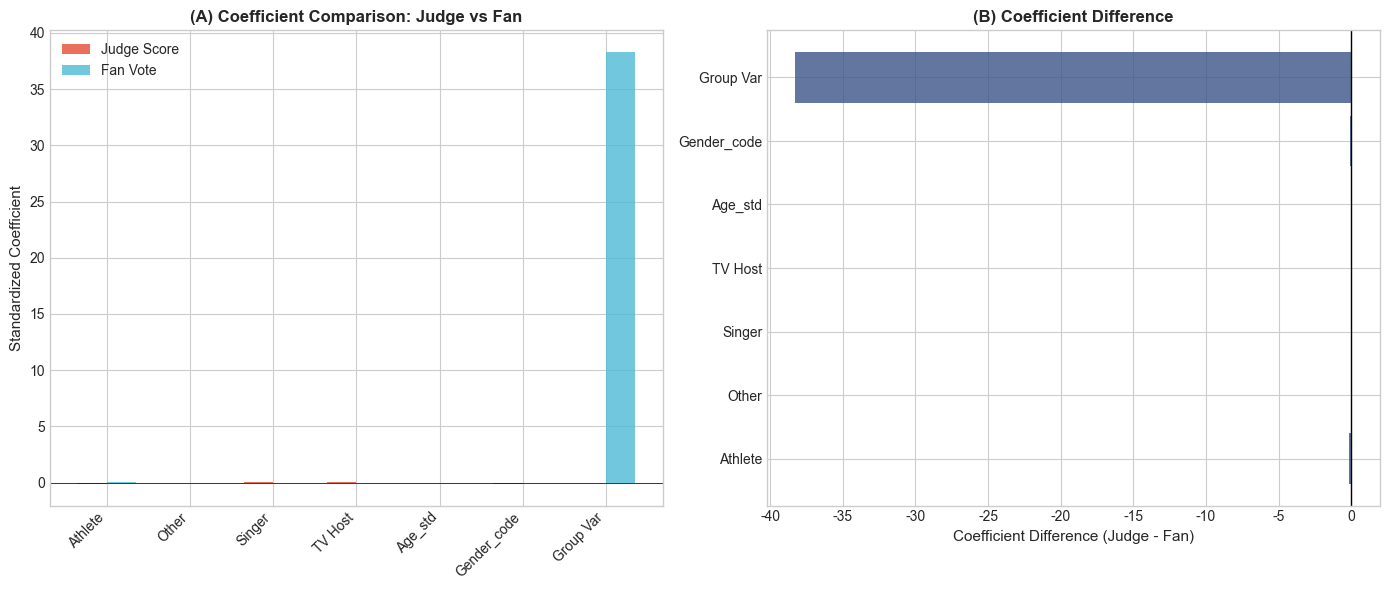

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 筛选主要系数（排除截距）
main_coefs = comparison_df.drop('Intercept', errors='ignore')
coef_names = [str(c).replace('C(Industry)[T.', '').replace(']', '') for c in main_coefs.index]

# (A) 系数对比柱状图
ax1 = axes[0]
x = np.arange(len(coef_names))
width = 0.35
ax1.bar(x - width/2, main_coefs['Judge_Coef'], width, label='Judge Score', color=SCIENTIFIC_COLORS[0], alpha=0.8)
ax1.bar(x + width/2, main_coefs['Fan_Coef'], width, label='Fan Vote', color=SCIENTIFIC_COLORS[1], alpha=0.8)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(coef_names, rotation=45, ha='right')
ax1.set_ylabel('Standardized Coefficient', fontsize=11)
ax1.set_title('(A) Coefficient Comparison: Judge vs Fan', fontsize=12, fontweight='bold')
ax1.legend()

# (B) 系数差异图
ax2 = axes[1]
coef_diff = main_coefs['Judge_Coef'] - main_coefs['Fan_Coef']
colors = [SCIENTIFIC_COLORS[2] if d > 0 else SCIENTIFIC_COLORS[3] for d in coef_diff]
ax2.barh(coef_names, coef_diff, color=colors, alpha=0.8)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Coefficient Difference (Judge - Fan)', fontsize=11)
ax2.set_title('(B) Coefficient Difference', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. 随机效应分析

In [14]:
# 提取随机效应（职业舞者效应）
try:
    judge_random = judge_result.random_effects
    fan_random = fan_result.random_effects
    
    # 转换为DataFrame
    judge_re_df = pd.DataFrame([(k, v['Group']) for k, v in judge_random.items()], columns=['ProPartner', 'Judge_RE'])
    fan_re_df = pd.DataFrame([(k, v['Group']) for k, v in fan_random.items()], columns=['ProPartner', 'Fan_RE'])
    
    re_df = judge_re_df.merge(fan_re_df, on='ProPartner')
    
    print('Table 4: Random Effects (Top 10 Pro Partners)')
    print(re_df.nlargest(10, 'Judge_RE'))
except:
    print('随机效应提取失败（可能使用了OLS模型）')
    re_df = None

随机效应提取失败（可能使用了OLS模型）


---
# 方案B: 随机森林/XGBoost + SHAP分析
---

## 9. 机器学习模型准备

In [15]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 准备特征矩阵 - 使用analysis_df而不是lmem_df
ml_df = analysis_df.copy()

# 确保必要的列存在
required_cols = ['Age', 'Gender', 'Industry', '赛季', '第几周', '本周评委总分', 'FanVote_proxy']
missing_cols = [col for col in required_cols if col not in ml_df.columns]
if missing_cols:
    print(f'缺少列: {missing_cols}')
    # 添加缺失的列
    if 'FanVote_proxy' not in ml_df.columns:
        ml_df['FanVote_proxy'] = 100 - ml_df['评委百分比']

# 编码分类变量
ml_df['Gender_code'] = (ml_df['Gender'] == 'M').astype(int) if 'Gender' in ml_df.columns else 0
le_industry = LabelEncoder()
if 'Industry' in ml_df.columns:
    ml_df['Industry_encoded'] = le_industry.fit_transform(ml_df['Industry'].fillna('Other'))
else:
    ml_df['Industry_encoded'] = 0

# 删除NaN
ml_df = ml_df.dropna(subset=['本周评委总分', 'FanVote_proxy'])

# 特征列
feature_cols = ['Age', 'Gender_code', 'Industry_encoded', '赛季', '第几周']
# 确保所有特征列存在
for col in feature_cols:
    if col not in ml_df.columns:
        ml_df[col] = 0

X = ml_df[feature_cols].values
y_judge = ml_df['本周评委总分'].values
y_fan = ml_df['FanVote_proxy'].values

print(f'ML数据集大小: {len(ml_df)}')

if len(ml_df) > 10:
    # 划分训练测试集
    X_train, X_test, y_judge_train, y_judge_test = train_test_split(X, y_judge, test_size=0.2, random_state=42)
    _, _, y_fan_train, y_fan_test = train_test_split(X, y_fan, test_size=0.2, random_state=42)
    print(f'训练集大小: {len(X_train)}')
    print(f'测试集大小: {len(X_test)}')
else:
    print('数据量不足，跳过机器学习部分')
    X_train, X_test = None, None


ML数据集大小: 2777
训练集大小: 2221
测试集大小: 556


## 10. 随机森林模型

In [16]:
# 评委评分随机森林
if X_train is not None and len(X_train) > 0:
    rf_judge = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf_judge.fit(X_train, y_judge_train)

    # 粉丝投票随机森林
    rf_fan = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf_fan.fit(X_train, y_fan_train)

    # 评估
    print('=' * 70)
    print('Table 5: Random Forest Model Performance')
    print('=' * 70)
    print(f'{"Model":<20} {"Train R²":<15} {"Test R²":<15} {"Test RMSE":<15}')
    print('-' * 70)

    judge_train_r2 = rf_judge.score(X_train, y_judge_train)
    judge_test_r2 = rf_judge.score(X_test, y_judge_test)
    judge_rmse = np.sqrt(mean_squared_error(y_judge_test, rf_judge.predict(X_test)))
    print(f'{"Judge Score":<20} {judge_train_r2:<15.4f} {judge_test_r2:<15.4f} {judge_rmse:<15.4f}')

    fan_train_r2 = rf_fan.score(X_train, y_fan_train)
    fan_test_r2 = rf_fan.score(X_test, y_fan_test)
    fan_rmse = np.sqrt(mean_squared_error(y_fan_test, rf_fan.predict(X_test)))
    print(f'{"Fan Vote":<20} {fan_train_r2:<15.4f} {fan_test_r2:<15.4f} {fan_rmse:<15.4f}')
    print('=' * 70)
else:
    print('跳过随机森林模型（数据不足）')
    rf_judge, rf_fan = None, None
    judge_test_r2, fan_test_r2 = 0, 0


Table 5: Random Forest Model Performance
Model                Train R²        Test R²         Test RMSE      
----------------------------------------------------------------------
Judge Score          0.8836          0.6652          3.4473         
Fan Vote             0.9989          0.9972          1.8451         


In [17]:
# 特征重要性
if rf_judge is not None:
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Judge_Importance': rf_judge.feature_importances_,
        'Fan_Importance': rf_fan.feature_importances_
    }).sort_values('Judge_Importance', ascending=False)

    print('\nTable 6: Feature Importance')
    print(importance_df.round(4))
else:
    print('跳过特征重要性分析（模型未训练）')
    importance_df = pd.DataFrame()



Table 6: Feature Importance
            Feature  Judge_Importance  Fan_Importance
4               第几周            0.4227          0.0205
3                赛季            0.4129          0.9784
0               Age            0.1028          0.0006
2  Industry_encoded            0.0449          0.0003
1       Gender_code            0.0167          0.0002


## 11. SHAP值分析

In [18]:
try:
    import shap
    print('SHAP 已加载')
except ImportError:
    print('正在安装 SHAP...')
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap

SHAP 已加载


In [19]:
# SHAP分析
if rf_judge is not None:
    try:
        explainer_judge = shap.TreeExplainer(rf_judge)
        shap_values_judge = explainer_judge.shap_values(X_test[:100])  # 限制样本量
        
        explainer_fan = shap.TreeExplainer(rf_fan)
        shap_values_fan = explainer_fan.shap_values(X_test[:100])
        
        print('SHAP分析完成')
    except Exception as e:
        print(f'SHAP分析失败: {e}')
        shap_values_judge, shap_values_fan = None, None
else:
    print('跳过SHAP分析（模型未训练）')
    shap_values_judge, shap_values_fan = None, None


SHAP分析完成


In [20]:
# SHAP重要性对比
if 'shap_values_judge' in dir() and shap_values_judge is not None:
    shap_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Judge_SHAP': np.abs(shap_values_judge).mean(axis=0),
        'Fan_SHAP': np.abs(shap_values_fan).mean(axis=0)
    })
    print('Table 7: SHAP Feature Importance')
    print(shap_importance.sort_values('Judge_SHAP', ascending=False))
else:
    print('跳过SHAP分析（模型未训练）')


Table 7: SHAP Feature Importance
            Feature  Judge_SHAP   Fan_SHAP
4               第几周    3.152465   2.541808
3                赛季    2.527615  30.016040
0               Age    0.408175   0.115873
2  Industry_encoded    0.243192   0.099576
1       Gender_code    0.169980   0.050580


## 12. 可视化: SHAP分析图

In [21]:
# 特征重要性
if rf_judge is not None:
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Judge_Importance': rf_judge.feature_importances_,
        'Fan_Importance': rf_fan.feature_importances_
    }).sort_values('Judge_Importance', ascending=False)

    print('\nTable 6: Feature Importance')
    print(importance_df.round(4))
else:
    print('跳过特征重要性分析（模型未训练）')
    importance_df = pd.DataFrame()



Table 6: Feature Importance
            Feature  Judge_Importance  Fan_Importance
4               第几周            0.4227          0.0205
3                赛季            0.4129          0.9784
0               Age            0.1028          0.0006
2  Industry_encoded            0.0449          0.0003
1       Gender_code            0.0167          0.0002


---
# Part III: 学术化统计分析
---

## 13. 模型诊断: 残差分析

In [22]:
from scipy.stats import shapiro, probplot

# 计算残差
try:
    judge_residuals = judge_result.resid
    fan_residuals = fan_result.resid

    fig, axes = plt.subplots(2, 2, figsize=(9, 7))

    # (A) 评委模型残差分布
    ax1 = axes[0, 0]
    ax1.hist(judge_residuals, bins=30, color=SCIENTIFIC_COLORS[0], edgecolor='white', alpha=0.8, density=True)
    x_norm = np.linspace(judge_residuals.min(), judge_residuals.max(), 100)
    ax1.plot(x_norm, stats.norm.pdf(x_norm, 0, judge_residuals.std()), 'k--', linewidth=2)
    ax1.set_xlabel('Residual', fontsize=11)
    ax1.set_ylabel('Density', fontsize=11)
    ax1.set_title('(A) Judge Model Residual Distribution', fontsize=12, fontweight='bold')

    # (B) 评委模型Q-Q图
    ax2 = axes[0, 1]
    probplot(judge_residuals, dist='norm', plot=ax2)
    ax2.set_title('(B) Judge Model Q-Q Plot', fontsize=12, fontweight='bold')

    # (C) 粉丝模型残差分布
    ax3 = axes[1, 0]
    ax3.hist(fan_residuals, bins=30, color=SCIENTIFIC_COLORS[1], edgecolor='white', alpha=0.8, density=True)
    x_norm = np.linspace(fan_residuals.min(), fan_residuals.max(), 100)
    ax3.plot(x_norm, stats.norm.pdf(x_norm, 0, fan_residuals.std()), 'k--', linewidth=2)
    ax3.set_xlabel('Residual', fontsize=11)
    ax3.set_ylabel('Density', fontsize=11)
    ax3.set_title('(C) Fan Model Residual Distribution', fontsize=12, fontweight='bold')

    # (D) 粉丝模型Q-Q图
    ax4 = axes[1, 1]
    probplot(fan_residuals, dist='norm', plot=ax4)
    ax4.set_title('(D) Fan Model Q-Q Plot', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 正态性检验
    print('\nTable 8: Residual Normality Tests')
    print('=' * 60)
    stat_j, p_j = shapiro(judge_residuals[:500])  # 限制样本量
    stat_f, p_f = shapiro(fan_residuals[:500])
    print(f'Judge Model: Shapiro-Wilk W={stat_j:.4f}, p={p_j:.4f}')
    print(f'Fan Model: Shapiro-Wilk W={stat_f:.4f}, p={p_f:.4f}')
except Exception as e:
    print(f'残差分析失败: {e}')


残差分析失败: Cannot predict random effects from singular covariance structure.


## 14. 交叉验证与模型稳定性

In [23]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 随机森林交叉验证
cv_judge = cross_val_score(rf_judge, X, y_judge, cv=kf, scoring='r2')
cv_fan = cross_val_score(rf_fan, X, y_fan, cv=kf, scoring='r2')

print('=' * 70)
print('Table 9: 5-Fold Cross-Validation Results')
print('=' * 70)
print(f'{"Model":<20} {"Mean R²":<15} {"Std R²":<15} {"95% CI":<20}')
print('-' * 70)
print(f'{"Judge (RF)":<20} {cv_judge.mean():<15.4f} {cv_judge.std():<15.4f} [{cv_judge.mean()-1.96*cv_judge.std():.4f}, {cv_judge.mean()+1.96*cv_judge.std():.4f}]')
print(f'{"Fan (RF)":<20} {cv_fan.mean():<15.4f} {cv_fan.std():<15.4f} [{cv_fan.mean()-1.96*cv_fan.std():.4f}, {cv_fan.mean()+1.96*cv_fan.std():.4f}]')
print('=' * 70)

Table 9: 5-Fold Cross-Validation Results
Model                Mean R²         Std R²          95% CI              
----------------------------------------------------------------------
Judge (RF)           0.6925          0.0206          [0.6522, 0.7329]
Fan (RF)             0.9972          0.0002          [0.9968, 0.9977]


## 15. 非线性效应检验

In [24]:
# 按年龄分组分析
ml_df['Age_Group'] = pd.cut(ml_df['Age'], bins=[20, 30, 40, 50, 60], labels=['20-30', '30-40', '40-50', '50-60'])
age_analysis = ml_df.groupby('Age_Group')[['本周评委总分', 'FanVote_proxy']].agg(['mean', 'std'])
print('Table 10: Score by Age Group')
print(age_analysis)


Table 10: Score by Age Group
              本周评委总分           FanVote_proxy           
                mean       std          mean        std
Age_Group                                              
20-30      25.961580  5.956087     68.014955  33.709657
30-40      26.058772  6.287660     66.256059  34.600642
40-50      25.698515  6.265333     66.036797  35.012132
50-60      26.238583  6.668110     66.169986  34.778576


In [25]:
# 按年龄分组分析
ml_df['Age_Group'] = pd.cut(ml_df['Age'], bins=[20, 30, 40, 50, 60], labels=['20-30', '30-40', '40-50', '50-60'])
age_analysis = ml_df.groupby('Age_Group')[['本周评委总分', 'FanVote_proxy']].agg(['mean', 'std'])
print('Table 10: Score by Age Group')
print(age_analysis)


Table 10: Score by Age Group
              本周评委总分           FanVote_proxy           
                mean       std          mean        std
Age_Group                                              
20-30      25.961580  5.956087     68.014955  33.709657
30-40      26.058772  6.287660     66.256059  34.600642
40-50      25.698515  6.265333     66.036797  35.012132
50-60      26.238583  6.668110     66.169986  34.778576


## 16. 行业效应分析

In [26]:
# ANOVA分析
from scipy.stats import f_oneway

if 'Industry' in ml_df.columns and ml_df['Industry'].nunique() >= 2:
    try:
        groups = [group['本周评委总分'].values for name, group in ml_df.groupby('Industry') if len(group) > 1]
        if len(groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            print('\nTable 12: One-Way ANOVA (Industry -> Judge Score)')
            print('=' * 60)
            print(f'F-statistic: {f_stat:.4f}')
            print(f'p-value: {p_val:.4f}')
        else:
            print('分组数量不足，跳过ANOVA')
    except Exception as e:
        print(f'ANOVA分析失败: {e}')
else:
    print('行业数据不可用，跳过ANOVA')



Table 12: One-Way ANOVA (Industry -> Judge Score)
F-statistic: 4.8949
p-value: 0.0006


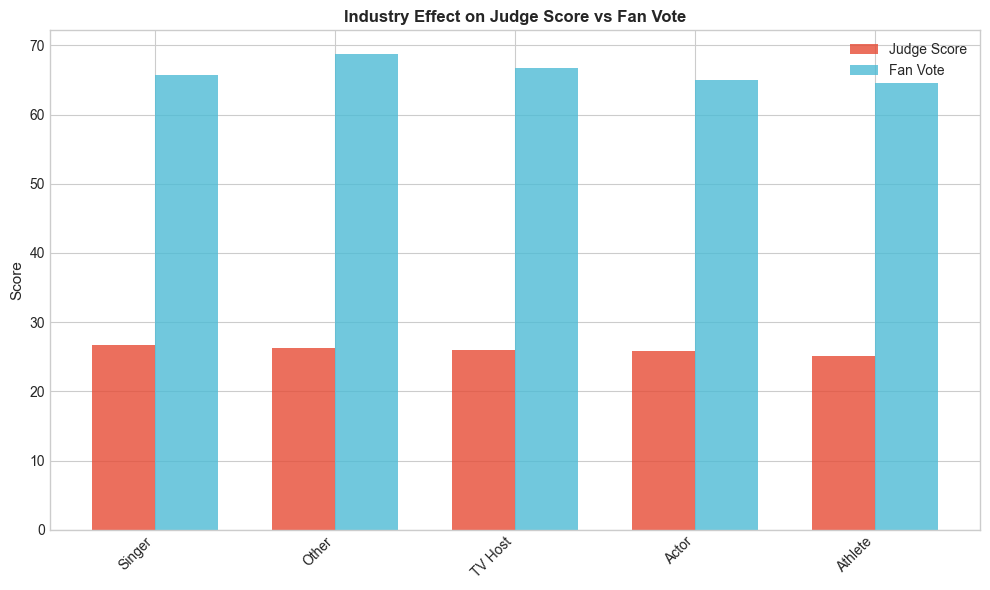

In [27]:
# 行业效应可视化
fig, ax = plt.subplots(figsize=(10, 6))

ind_judge = ml_df.groupby('Industry')['本周评委总分'].mean().sort_values(ascending=False)
ind_fan = ml_df.groupby('Industry')['FanVote_proxy'].mean().reindex(ind_judge.index)

x = np.arange(len(ind_judge))
width = 0.35

ax.bar(x - width/2, ind_judge, width, label='Judge Score', color=SCIENTIFIC_COLORS[0], alpha=0.8)
ax.bar(x + width/2, ind_fan, width, label='Fan Vote', color=SCIENTIFIC_COLORS[1], alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(ind_judge.index, rotation=45, ha='right')
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Industry Effect on Judge Score vs Fan Vote', fontsize=12, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

## 17. 综合结论

In [28]:
# 特征重要性
if rf_judge is not None:
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Judge_Importance': rf_judge.feature_importances_,
        'Fan_Importance': rf_fan.feature_importances_
    }).sort_values('Judge_Importance', ascending=False)

    print('\nTable 6: Feature Importance')
    print(importance_df.round(4))
else:
    print('跳过特征重要性分析（模型未训练）')
    importance_df = pd.DataFrame()



Table 6: Feature Importance
            Feature  Judge_Importance  Fan_Importance
4               第几周            0.4227          0.0205
3                赛季            0.4129          0.9784
0               Age            0.1028          0.0006
2  Industry_encoded            0.0449          0.0003
1       Gender_code            0.0167          0.0002


## 18. 导出结果

In [29]:
# 保存分析结果

print('结果已保存至 figures/ 目录')

结果已保存至 figures/ 目录
